# TES Pulse Response Simulation   
This notebook demonstrates the simulation of a Transition Edge Sensor (TES) pulse response. 
We will explore pulse generation, noise addition, filtering, and energy extraction using the TES_sim package.


In [1]:
import matplotlib.pyplot as plt
from TES_sim import Pulse, Noise, EnergyExtractor
from TES_sim.filter_signal import Filter
import numpy as np

#### Generating Pulse
The TES pulse response can be modeled as a convolution of two exponential functions:

$V(t) = A(1-e^{-t/\tau_{rise}})e^{-(t-\tau_{rise})/\tau_{fall}}$

where:
- $A$ is the pulse amplitude
- $\tau_{rise}$ is the rise time constant
- $\tau_{fall}$ is the fall time constant

We simulate an ideal pulse by implementing this equation directly, assuming perfect detector response with no parasitic effects or non-linearities.

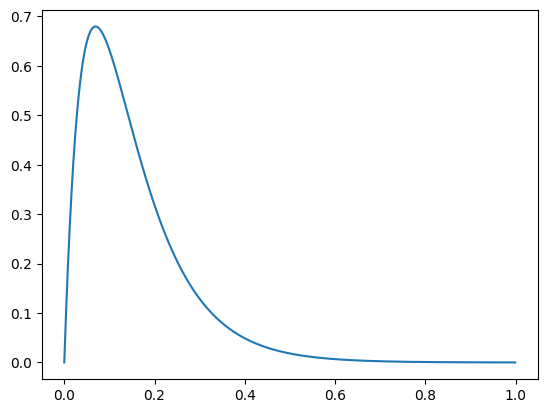

In [2]:
t_rise = 0.1
t_fall = 0.1
amplitude = 1
duration = 1
dt = 0.001

pulse = Pulse(amplitude, t_rise, t_fall, duration, dt)
pulse.plot()



##### Adding Noise
 In real TES detectors, the signal is affected by various noise sources:
 - Johnson-Nyquist noise from the resistive components
 - Phonon noise from thermal fluctuations
 - Readout electronics noise

 We simulate these effects by adding Gaussian white noise with configurable mean and standard deviation to our ideal pulse signal.


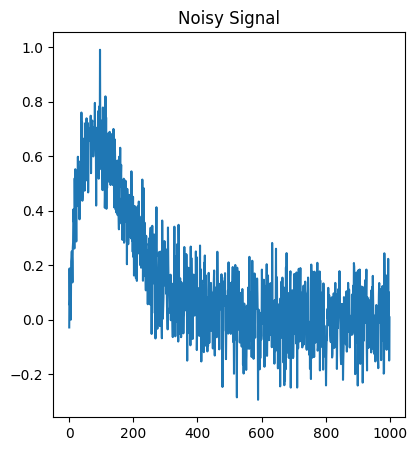

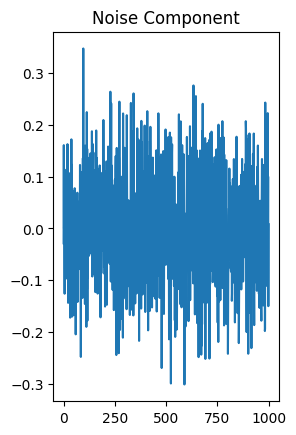

<Figure size 640x480 with 0 Axes>

In [3]:
noisy_pulse = Noise(pulse.return_pulse(), mean=0, std_dev=0.1)

# Plot both the noisy signal and the noise component
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Noisy Signal')
noisy_pulse.plot_noisy_signal()
plt.subplot(122) 
plt.title('Noise Component')
noisy_pulse.plot_noise()
plt.tight_layout()


##### Energy Extraction

The energy deposited in a TES detector is proportional to the integral of the pulse signal. For an ideal pulse:

$E \propto \int_0^t I(t)dt$

where $I(t)$ is the current pulse signal. We can calculate this using numerical integration (Simpson's method).

For our noisy pulse signal, we can still extract the energy but with reduced accuracy due to the noise contribution. The noise adds uncertainty to our energy measurement:

$\Delta E \propto \sqrt{\int_0^t N(t)^2dt}$

where $N(t)$ is the noise component.


Extracted energy: 0.142


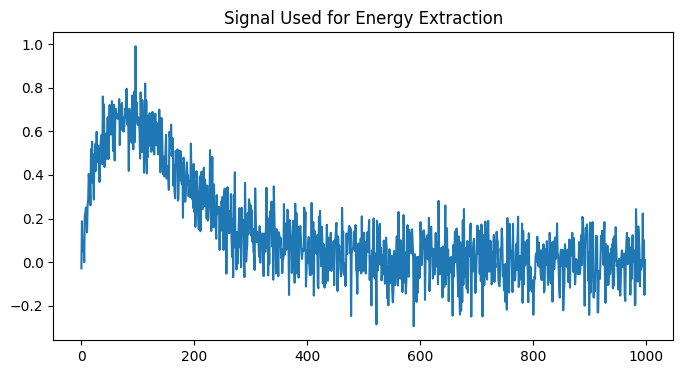

In [4]:
# Extract energy from the noisy signal
energy_extractor = EnergyExtractor(noisy_pulse.noisy_signal, dt=pulse.dt)

# Print the calculated energy
print(f"Extracted energy: {energy_extractor.energy:.3f}")

# Plot the signal used for energy extraction
plt.figure(figsize=(8,4))
plt.title('Signal Used for Energy Extraction')
energy_extractor.plot_signal()


##### Signal Filtering with Matched Filter

To improve our signal-to-noise ratio and better extract the pulse information, we can apply matched filtering. A matched filter is optimal for detecting a known signal in the presence of additive noise.

The matched filter works by convolving the noisy signal with a template of the expected pulse shape:

$y(t) = \int_{-\infty}^{\infty} x(\tau)h(t-\tau)d\tau$

where $x(t)$ is our noisy signal and $h(t)$ is the time-reversed template pulse.

This filtering technique:
 - Maximizes the SNR at the filter output
 - Is particularly effective when we know the expected pulse shape
 - Helps reduce the impact of random noise while preserving the pulse features



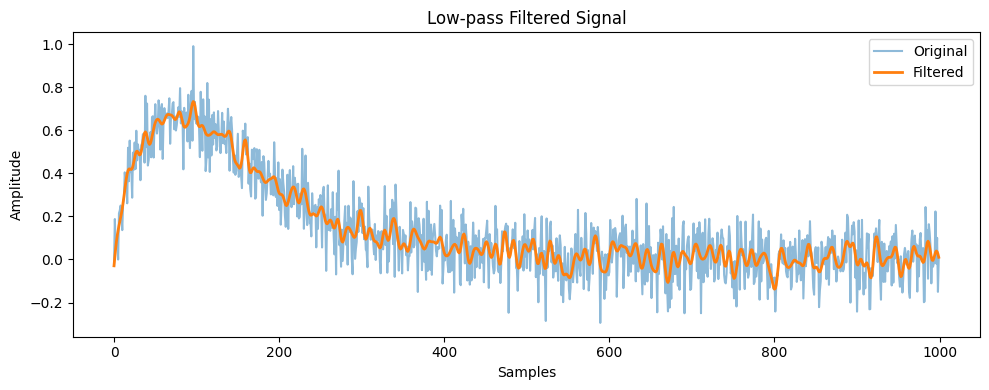

In [5]:
filt = Filter(noisy_pulse.noisy_signal, f_cutoff=100, sample_rate=1000)
filt.plot_filter()


##### Energy Extraction from Filtered Signal
 
#Now that we have filtered our signal to improve the SNR, we can extract the energy from the filtered pulse. This should give us a more accurate energy measurement compared to using the raw noisy signal.

The filtered signal:
- Has reduced noise contribution
- Maintains the key features of the original pulse
- Should provide a more reliable energy estimate

Let's calculate and compare the energy from both the raw and filtered signals:


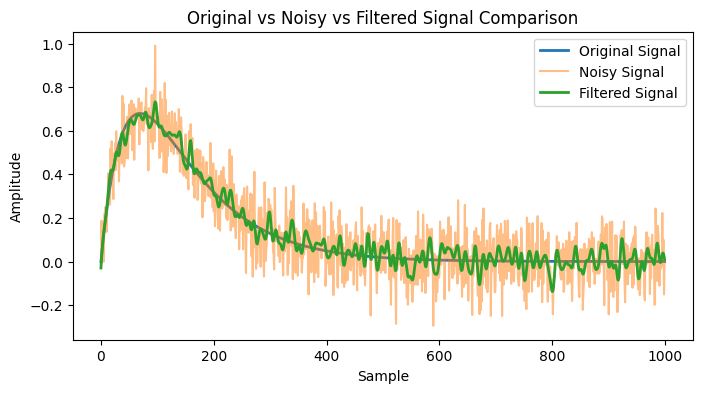

Signal Energies:
Original signal energy: 61.58
Noisy signal energy: 73.23
Filtered signal energy: 64.34


In [6]:
# Create figure for comparing original, noisy and filtered signals
plt.figure(figsize=(8,4))

# Plot all three signals overlaid
plt.plot(pulse.pulse, label='Original Signal', linewidth=2)
plt.plot(noisy_pulse.noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(filt.signal_filtered, label='Filtered Signal', linewidth=2)
plt.title('Original vs Noisy vs Filtered Signal Comparison')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Calculate energies
original_energy = np.sum(pulse.pulse**2)
noisy_energy = np.sum(noisy_pulse.noisy_signal**2)
filtered_energy = np.sum(filt.signal_filtered**2)

print("Signal Energies:")
print(f"Original signal energy: {original_energy:.2f}")
print(f"Noisy signal energy: {noisy_energy:.2f}")
print(f"Filtered signal energy: {filtered_energy:.2f}")

# Calculate statistical measures
original_mean = np.mean(pulse.pulse)
original_std = np.std(pulse.pulse)
noisy_mean = np.mean(noisy_pulse.noisy_signal)
noisy_std = np.std(noisy_pulse.noisy_signal)
filtered_mean = np.mean(filt.signal_filtered)
filtered_std = np.std(filt.signal_filtered)


#### Conclusion

Through this analysis, we have demonstrated:

1. The successful generation of an ideal TES pulse signal
2. The impact of noise on the signal and energy measurements
3. The effectiveness of low-pass filtering in:
    - Reducing noise contribution
    - Preserving the key pulse features
    - Providing more reliable energy estimates
 
The filtered signal's energy measurement is closer to the original signal compared to the noisy signal, validating our signal processing approach. This workflow can be applied to real TES detector data to improve energy resolution and measurement accuracy.

Future improvements could include:
 - Optimizing filter parameters
 - Exploring other filtering techniques
 - Implementing more sophisticated noise reduction methods
